## Import libraries

In [214]:
## Importing nessesary libraries and mounting drive
import os
import math
import torch
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from functools import partial
from collections import Counter
from torchvision import transforms
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import logging

from google.colab import drive
drive.mount('/content/drive')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Locate data and image directory
data_dir = "/content/drive/MyDrive/Im2Latex/Dataset"
img_dir = '/content/drive/MyDrive/Im2Latex/Dataset/formula_images/formula_images_processed/formula_images_processed'
print(f"Files in data directory:")
for file in os.listdir(data_dir):
  print(f"  {file}")

Files in data directory:
  im2latex_formulas.norm.csv
  formula_images
  m_train.csv
  m_val.csv
  m_test.csv
  model_weights.pth
  10000_model_weights_0129_v2.pth
  10000_model_weights_0129_v1.pth
  10000_model_weights_0110_v1.pth
  10000_model_weights_0129_v3.pth


## Im2Tex data

The ```Im2Tex``` data is a pandas table containing two columns. The formula column contains latex formulas, while the image column contains the image name.

In [3]:
# Printing raw_data
raw_data = pd.read_csv(os.path.join(data_dir, "m_train.csv"))
raw_data.head()

,formula,image
0,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",1cbb05a562.png
1,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",242a58bc3a.png
2,s = { \frac { S } { V } } = { \frac { A _ { H ...,73fdf824d0.png
3,\psi ( \gamma ) = \operatorname { e x p } { - ...,35a6b52146.png
4,K _ { \mu \nu } ~ = ~ \frac { 1 } { 2 } \dot {...,2ae8eccc13.png


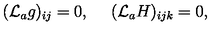

In [5]:
# Sample image
img_name = raw_data.iloc[0]["image"]
img = Image.open(os.path.join(img_dir, img_name))
img

In [81]:
print(f"The size of image: {img.size}")

The size of image: (224, 32)


## Vocab class

The vocab class is responsible for two task: <br>
> 1. Storing a dictionary that converts tokens to numbers and vice versa (store in ```stoi``` and ```itos```)
> 2. Converting a text sentence to a numbered sentence (using ```formula_to_sign``` and ```sign_to_formula``` method) <br>

The ```build_vocab``` method is used to build the dictionary.

In [6]:
# Set training samples to 10000
train_samples = 10000

In [7]:
# Special tokens
START_TOKEN = 0
PAD_TOKEN = 1
END_TOKEN = 2
UNK_TOKEN = 3

In [8]:
# Extracting the list of formulas
formula_list = pd.read_csv(os.path.join(data_dir, "m_train.csv"))["formula"].tolist()[:train_samples]
print(f"Length of formula list: {len(formula_list)}")

Length of formula list: 10000


In [9]:
# Vocab class
#     add_sign: adds a new token to the dictionary
#     build_vocab: builds the dictionary
#     formula_to_sign: converts a text formula to numbered formula
#     sign_to_formula: converts a numbered formula to text formula

class Vocab:
    def __init__(self, formulas, freq=2):
        self.formulas = formulas
        self.stoi = {"<sos>": START_TOKEN, "<eos>": END_TOKEN,
                     "<pad>": PAD_TOKEN, "<unk>": UNK_TOKEN}
        self.itos = dict((idx, token) for token, idx in self.stoi.items())
        self.length = 4
        self.counter = Counter()
        self.freq = freq
        self.build_vocab()

    def add_sign(self, sign):
        self.stoi[sign] = self.length
        self.itos[self.length] = sign
        self.length += 1

    def build_vocab(self):
        for formula in self.formulas:
            for token in formula.split():
                self.counter.update([token])

        for token, count in self.counter.items():
            if count >= self.freq:
                self.add_sign(token)

    def formula_to_sign(self, formula):
        signed = []
        for token in formula.split():
            if token in self.stoi:
                signed.append(self.stoi[token])
            else:
                signed.append(UNK_TOKEN)
        return torch.tensor(signed)

    def sign_to_formula(self, signed):
        formula = []
        for sign in signed:
            if sign.item() in self.itos:
                formula.append(self.itos[sign.item()])
        return formula

In [10]:
vocab = Vocab(formula_list)
print(f"Length of dictionary: {vocab.length}")

Length of dictionary: 378


## Dataset class

The ```Im2TexDataset``` class inherits from the ```Dataset``` class and contains two methods: ```__len__``` and ```__getitem__```. <br>
<br>
The ```Im2TexDataset``` class also preprocesses the images by scaling them to the same size (```[64, 256]```)

In [11]:
# Im2TexDataset
#     __len__: returns the length of the dataset
#     __getitem__: returns the idx element in the dataset

class Im2TexDataset(Dataset):
    def __init__(self, img_dir, formula_dir, vocab, n_samples=train_samples):
        self.img_dir = img_dir
        self.data = pd.read_csv(formula_dir, nrows=n_samples)
        self.transform = transforms.Compose([
                             transforms.Resize((64, 256)),
                             transforms.ToTensor(),
                         ])
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, formula = self.data.iloc[idx][1], self.data.iloc[idx][0]
        img = Image.open(os.path.join(self.img_dir, img_name))
        img = self.transform(img)
        formula = self.vocab.formula_to_sign(formula)
        return img, formula

## Methods for dataloader

The `collate_fn` method is an argument for the `DataLoader` class. It takes in an (image, formula) batch and returns (image, input_formula, output_formula). <br>
<br>
The image is not preprocessed. The input and output formula is generated as follows: suppose the formula is `[23, 43, 20, 11, 14]`. Then
> 1. Input formula: `[0, 23, 43, 20, 11, 14]` (the start token is appended front) <br>
> 2. Output formula: `[23, 43, 20, 11, 14, 2]` (the end token is appended at the end) <br>

These formulas are then padded to a particular length

In [12]:
def collate_fn(batch):
    img = torch.stack([elem[0] for elem in batch])
    formulas = [elem[1] for elem in batch]
    max_len = len(max(formulas, key=lambda x: len(x))) + 1
    in_for = [torch.cat((torch.tensor([START_TOKEN]), formula))for formula in formulas]
    out_for = [torch.cat((formula, torch.tensor([END_TOKEN])))for formula in formulas]
    in_for = pad(in_for, max_len)
    out_for = pad(out_for, max_len)
    return img, in_for, out_for

def pad(formulas, size):
    padded = []
    for formula in formulas:
        while len(formula) < size:
            formula = torch.cat((formula, torch.tensor([PAD_TOKEN])))
        padded.append(formula)
    return torch.stack(padded)

## Encoder module

The ```Encoder``` module firsts passes the images (shape: `[B, H, W, C]`) through a sequence of convolution layers with max pooling. The output is then flattened (shape: `[B, H*W, C]`) and positional encoding is added <br>
<br>
The code for positional encoding is retrieved online.<br>
<br>
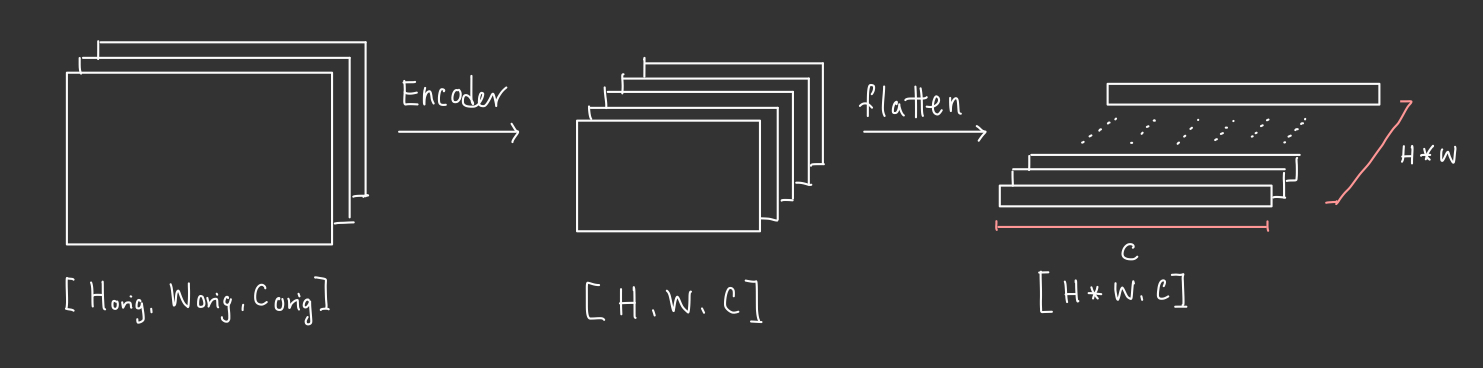

In [13]:
# Code for positional encoding is taken from: https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6

def add_positional_features(tensor: torch.Tensor,
                            min_timescale: float = 1.0,
                            max_timescale: float = 1.0e4):
    _, timesteps, hidden_dim = tensor.size()

    timestep_range = get_range_vector(timesteps, tensor.device).data.float()
    num_timescales = hidden_dim // 2
    timescale_range = get_range_vector(
        num_timescales, tensor.device).data.float()

    log_timescale_increments = math.log(
        float(max_timescale) / float(min_timescale)) / float(num_timescales - 1)
    inverse_timescales = min_timescale * \
        torch.exp(timescale_range * -log_timescale_increments)
    scaled_time = timestep_range.unsqueeze(1) * inverse_timescales.unsqueeze(0)
    sinusoids = torch.randn(
        scaled_time.size(0), 2*scaled_time.size(1), device=tensor.device)
    sinusoids[:, ::2] = torch.sin(scaled_time)
    sinusoids[:, 1::2] = torch.sin(scaled_time)
    if hidden_dim % 2 != 0:
        sinusoids = torch.cat(
            [sinusoids, sinusoids.new_zeros(timesteps, 1)], 1)
    return tensor + sinusoids.unsqueeze(0)

def get_range_vector(size: int, device) -> torch.Tensor:
    return torch.arange(0, size, dtype=torch.long, device=device)

In [120]:
class Encoder(nn.Module):

    def __init__(self, enc_out_dim=512):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1), 0),

            nn.Conv2d(256, enc_out_dim, 3, 1, 0),
            nn.ReLU()
        )

    def forward(self, img):
        out = self.encoder(img)
        out = out.permute(0, 2, 3, 1)
        B, H, W, _ = out.shape
        out = out.contiguous().view(B, H*W, -1)
        out = add_positional_features(out)
        return out

## Decoder module

In [92]:
class Decoder(nn.Module):
    # Input size of LSTM: hidden_size + encoded_size (cat embedding (hidden size) and context vector)
    # Output size of LSTM: encoded_size
    # out_size = number of vocabs

    def __init__(self, encoded_size, hidden_size, out_size, emb_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.init_Wh = nn.Linear(encoded_size, hidden_size, bias=False)
        self.init_Wo = nn.Linear(encoded_size, hidden_size, bias=False)
        self.init_Wc = nn.Linear(encoded_size, hidden_size, bias=False)

        self.beta = nn.Parameter(torch.Tensor(encoded_size))
        nn.init.normal_(self.beta, mean=0, std=0.01)

        self.W1 = nn.Linear(encoded_size, encoded_size, bias=False)
        self.W2 = nn.Linear(hidden_size, encoded_size, bias=False)

        self.rnn = nn.LSTMCell(hidden_size + emb_size, hidden_size)

        self.W3 = nn.Linear(hidden_size + encoded_size, hidden_size, bias=False)
        self.W_out = nn.Linear(hidden_size, out_size, bias=False)
        self.embedding = nn.Embedding(num_embeddings=out_size, embedding_dim=emb_size, padding_idx=PAD_TOKEN)
        self.dropout = nn.Dropout(p=dropout)
        self.attention_cache = []

        self.c = None

    def forward(self, encoded_imgs, formulas, store_attention=False):
        dec_state, o_t = self.get_init_state(encoded_imgs)
        max_len = formulas.shape[1]
        logits = []
        for t in range(max_len):
            text = formulas[:, t:t+1]
            dec_states, o_t, logit = self.one_step_decode(
                text, encoded_imgs, dec_state, o_t, store_attention)
            logits.append(logit)
        logits = torch.stack(logits, dim=1)  # [B, MAX_LEN, out_size]
        return logits

    def one_step_decode(self, text, enc_out, dec_state, o_t, store_attention=False):
        embed = self.embedding(text).squeeze(dim=1) # [B, 1, O] -> [B, O]
        inp = torch.cat([embed, o_t], dim=1)
        h_t, c_t = self.rnn(inp, dec_state)
        h_t = self.dropout(h_t)
        c_t = self.dropout(c_t)

        # context_t : [B, C]
        context_t, attn_scores = self.get_attention_weights(enc_out, h_t)

        if store_attention:
           self.attention_cache.append(attn_scores)

        # [B, dec_rnn_h]
        o_t = self.W3(torch.cat([h_t, context_t], dim=1)).tanh()
        o_t = self.dropout(o_t)
        logit = F.softmax(self.W_out(o_t), dim=1)  # [B, out_size]

        return (h_t, c_t), o_t, logit

    def get_attention_weights(self, enc_out, h_t):
        # enc_out: [B, L=H*W, C]
        # h_t: [B, H]
        #                     [B, L, C]     [B, C] -> [B, 1, C]
        alpha = torch.tanh(self.W1(enc_out) + self.W2(h_t).unsqueeze(1)) # [B, L, C]
        alpha = torch.sum(self.beta * alpha, dim=-1) #[B, L]
        alpha = F.softmax(alpha, dim=-1) # [B, L]

        #                    [B, 1, L]     [B, L, C]
        context = torch.bmm(alpha.unsqueeze(1), enc_out) #[B, 1, C]
        context = context.squeeze(1) #[B, C]
        return context, alpha

    def get_init_state(self, enc_out):
        h = self.get_init_h(enc_out)
        o = self.get_init_o(enc_out)
        c = self.get_init_c(enc_out)
        return (h, c), o

    # [B, H]
    def get_init_h(self, enc_out):
        mean = enc_out.mean(dim=1)
        out = torch.tanh(self.init_Wh(mean))
        return out

    # [B, H]
    def get_init_o(self, enc_out):
        mean = enc_out.mean(dim=1)
        out = torch.tanh(self.init_Wo(mean))
        return out

    # [B, H]
    def get_init_c(self, enc_out):
        mean = enc_out.mean(dim=1)
        out = torch.tanh(self.init_Wc(mean))
        return out

    def empty_attention_cache(self):
        self.attention_cache = []

## Im2Latex Model

The Im2Latex Model combines the encoder and decoder

In [93]:
class Im2Latex(nn.Module):

    def __init__(self, encoded_size, hidden_size, out_size, emb_size, dropout=0.1):
        super(Im2Latex, self).__init__()
        self.encoder = Encoder(encoded_size)
        self.decoder = Decoder(encoded_size, hidden_size, out_size, emb_size)

    def forward(self, imgs, formulas, store_attention=False):
        encoded_imgs = self.encoder(imgs)
        logits = self.decoder(encoded_imgs, formulas, store_attention=True)
        return logits

## Training Loop

In the training loop, the loss function is implemented that masked padding token.

In [17]:
def cal_loss(logits, targets):
    padding = torch.ones_like(targets) * PAD_TOKEN
    mask = (targets != padding)

    targets = targets.masked_select(mask)
    logits = logits.masked_select(
        mask.unsqueeze(2).expand(-1, -1, logits.size(2))
    ).contiguous().view(-1, logits.size(2))
    logits = torch.log(logits)

    assert logits.size(0) == targets.size(0)

    loss = F.nll_loss(logits, targets)
    return loss

In [18]:
## Implementation of the training loop
def train(model, train_loader, optimizer, num_epochs, val_loader=None):
    for epoch in range(num_epochs):
        total_loss = 0
        n = 0
        if val_loader is not None:
            val_iter = iter(val_loader)
        for imgs, in_for, out_for in train_loader:
            imgs, in_for, out_for = imgs.to(device), in_for.to(device), out_for.to(device)
            optimizer.zero_grad()
            logits = model.forward(imgs, in_for)
            loss = cal_loss(logits, out_for)
            loss.backward(retain_graph=True)
            optimizer.step()
            total_loss += loss.item()
            if n % 10 == 0:
                print(f"Loss: {loss.item()}")
            if n % 50 == 0:
                print(f"Logit contains nan: {torch.isnan(logits).any().item()}")
                if val_loader is not None:
                    imgs, in_for, out_for = next(val_iter)
                    imgs, in_for, out_for = imgs.to(device), in_for.to(device), out_for.to(device)
                    logits = model(imgs, in_for)
                    print(f"Validation loss: {cal_loss(logits, out_for)}")
            n += 1
        print(f"Epoch {epoch} with loss: {total_loss / n} ----------------------------------------")

## Training loop

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [20]:
train_dir = os.path.join(data_dir, "m_train.csv")
val_dir = os.path.join(data_dir, "m_val.csv")

In [21]:
train_data = Im2TexDataset(img_dir, train_dir, vocab)
val_data = Im2TexDataset(img_dir, val_dir, vocab)

In [22]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_data,
                          batch_size=32,
                          collate_fn=collate_fn)

In [23]:
encoded_size = 512
hidden_size = 512
out_size = vocab.length
emb_size = 80

In [94]:
model = Im2Latex(encoded_size, hidden_size, out_size, emb_size)
model.to(device)

Im2Latex(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (12): ReLU()
    )
  )
  (decoder): Decoder(
    (init_Wh): Linear(in_features=512, out_features=512, bias=False)
    (init_Wo): Linear(in_features=512, out_features=512, bias=False)
    (init_Wc): Linear(in_features=5

In [ ]:
learning_rate = 1e-6
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 2

In [ ]:
train(model, train_loader, optimizer, num_epochs, val_loader)

Loss: 0.7272881269454956
Logit contains nan: False
Validation loss: 0.8706469535827637
Loss: 0.6504067778587341
Loss: 0.6450098156929016
Loss: 0.5547589063644409
Loss: 0.638191819190979
Loss: 0.7574722170829773
Logit contains nan: False
Validation loss: 0.7510212063789368
Loss: 0.6224419474601746
Loss: 0.7738505601882935
Loss: 0.7794222235679626
Loss: 0.7773436903953552
Loss: 0.7511120438575745
Logit contains nan: False
Validation loss: 0.7437667846679688
Loss: 0.6296191215515137
Loss: 0.6302059888839722
Loss: 0.8190489411354065
Loss: 0.6599422693252563
Loss: 0.7584898471832275
Logit contains nan: False
Validation loss: 0.7466873526573181
Loss: 0.6570848226547241
Loss: 0.5956223011016846
Loss: 0.6193143129348755
Loss: 0.8940245509147644
Loss: 0.6092814207077026
Logit contains nan: False
Validation loss: 0.610556423664093
Loss: 0.6933060884475708
Loss: 0.833602786064148
Loss: 0.6305325031280518
Loss: 0.9013960361480713
Loss: 0.6741352081298828
Logit contains nan: False
Validation loss: 

In [ ]:
torch.save(model.state_dict(), os.path.join(data_dir, '10000_model_weights_0129_v3.pth'))

In [95]:
## Note: 10000_model_weights_0129_v3.pth is the best model
weights_path = os.path.join(data_dir, '10000_model_weights_0129_v3.pth')
model.load_state_dict(torch.load(weights_path, map_location=device))

<All keys matched successfully>

## Testing with greedy search

In [225]:
test_dir = os.path.join(data_dir, "m_test.csv")

In [226]:
test_data = Im2TexDataset(img_dir, test_dir, vocab)

In [227]:
test_loader = DataLoader(test_data,
                         batch_size=32,
                         collate_fn=collate_fn)

In [228]:
def evaluate(batch, search):
    t_img, t_in, t_out = batch
    t_img, t_in = t_img.to(device), t_in.to(device)
    t_logits = model.forward(t_img, t_in)
    predicted_words = []
    targets = []

    for t in range(len(t_logits)):
        predicted_words.append(search(t_logits[t]))
        targets.append(vocab.sign_to_formula(t_out[t]))

    return predicted_words, targets

In [229]:
def greedySearch(logit):
    words = []
    for token in logit:
        pred = torch.argmax(token)
        word = vocab.itos[pred.item()]
        words.append(word)
    return words

In [230]:
def toSentence(list_of_text):
    sentence = ""
    for t in range(len(list_of_text)):
        if list_of_text[t] == "<eos>":
            break
        sentence += list_of_text[t] + " "
    return sentence

In [231]:
batch = next(iter(test_loader))

In [232]:
predicted_words, targets = evaluate(batch, greedySearch)

In [233]:
for idx in range(10, 20):
  print(" ")
  print("*************************************************************************************************")
  print("*************************************************************************************************")
  print(" ")

  print(f"Target sentence:")
  print(f"{toSentence(targets[idx])}")
  print("-------------------------------------------------------------------------------------------------")
  print(f"Predicted sentence:")
  print(f"{toSentence(predicted_words[idx])}")

print(" ")
print("*************************************************************************************************")
print("*************************************************************************************************")

 
*************************************************************************************************
*************************************************************************************************
 
Target sentence:
\int \mathrm { d } ^ { 4 } x _ { 1 } ~ \cdots ~ \mathrm { d } ^ { 4 } x _ { n } ~ P _ { 4 } ( x _ { 1 } , \cdots , x _ { n } ) ~ \Gamma _ { x _ { 1 } \cdots x _ { n } 0 } = 0 
-------------------------------------------------------------------------------------------------
Predicted sentence:
\int \mathrm { d } ^ { 4 } x _ { 1 } \, \cdot \, d { d } ( { 4 } x _ { n } , P _ { 4 } ( x _ { 1 } , \cdots , x _ { n } ) \, \Gamma _ { x _ { n } } a _ { n } } } = 0 
 
*************************************************************************************************
*************************************************************************************************
 
Target sentence:
{ \xi } _ { i } ^ { \ast } , { p } _ { i } ^ { \ast } , \quad i = 2 , \dots , l + 1 
--------------------

## Testing with beam search

In [ ]:
def beam_search(logits, beam_width=8):
    sequences = [[list(), 0.0]]
    for row in logits:
        all_candidates = list()
        row = torch.softmax(torch.tensor(row), dim=-1).tolist()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - log(row[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    optimal_sequence = max(sequences, key=lambda tup: tup[1])[0]
    return optimal_sequence, sequences

In [ ]:
beam_predicted_words, targets = evaluate(batch, greedySearch)

In [ ]:
for idx in range(10, 20):
  print(" ")
  print("*************************************************************************************************")
  print("*************************************************************************************************")
  print(" ")

  print(f"Target sentence:")
  print(f"{toSentence(targets[idx])}")
  print("-------------------------------------------------------------------------------------------------")
  print(f"Predicted sentence:")
  print(f"{toSentence(beam_predicted_words[idx])}")

print(" ")
print("*************************************************************************************************")
print("*************************************************************************************************")

 
*************************************************************************************************
*************************************************************************************************
 
Target sentence:
\int \mathrm { d } ^ { 4 } x _ { 1 } ~ \cdots ~ \mathrm { d } ^ { 4 } x _ { n } ~ P _ { 4 } ( x _ { 1 } , \cdots , x _ { n } ) ~ \Gamma _ { x _ { 1 } \cdots x _ { n } 0 } = 0 
-------------------------------------------------------------------------------------------------
Predicted sentence:
\int d { d } ^ { 4 } x _ { 1 } \ \cdots \, \mathrm { d e ^ { 4 } x _ { n } , P _ { 4 } ( x _ { 1 } , \cdots , x _ { n } ) \, \Gamma _ { x , { n } } a _ { n } } } = 0 
 
*************************************************************************************************
*************************************************************************************************
 
Target sentence:
{ \xi } _ { i } ^ { \ast } , { p } _ { i } ^ { \ast } , \quad i = 2 , \dots , l + 1 
--------------------

## Embedding evaluations

In this section we attempt to visualize the trained embedding layer. The list of vocab is feeded into the embedding layer and the dimension of the resulting embeddings is projected to a 2D plane using PCA.

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [65]:
# Instantiating the vector to be embedded
list_of_vocabs = list(vocab.stoi.values())
to_be_embedded = torch.tensor(list_of_vocabs)
to_be_embedded = to_be_embedded.reshape(1, -1)
to_be_embedded = to_be_embedded.to(device)
print(to_be_embedded.shape)

torch.Size([1, 378])


In [66]:
# Feeds the vector into the embedding layer (378 words with embedding dimension of 80)
embedded_words = model.decoder.embedding(to_be_embedded)
embedded_words = embedded_words.squeeze(0)
print(embedded_words.shape)

torch.Size([378, 80])


In [67]:
# Use PCA to project the embeddings to 2D plane
pca = PCA(n_components=2)
embedded_words_cpu = embedded_words.cpu().detach().numpy()
embeddings_2d = pca.fit_transform(embedded_words_cpu)
print(embeddings_2d.shape)

(378, 2)


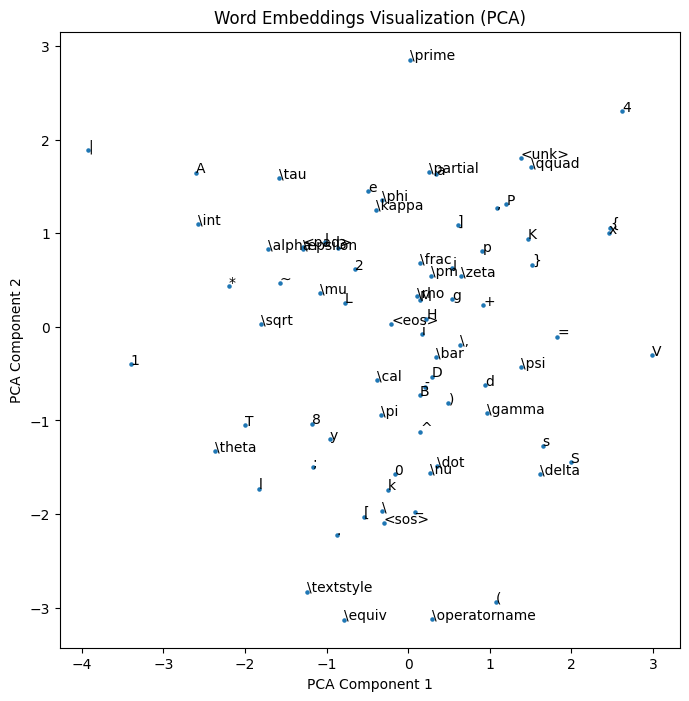

In [78]:
# Selecting top k words with highest occurence in data
k = 80
top_k_keys = [key for key, _ in vocab.counter.most_common(k)]
top_k_values = [vocab.stoi[key] for key in top_k_keys]
top_embeddings = embeddings_2d[top_k_values]

# Visualization of the selected embeddings
plt.figure(figsize=(8, 8))
plt.scatter(top_embeddings[:, 0], top_embeddings[:, 1], s=5)

for i in range(len(top_embeddings)):
    plt.annotate(vocab.itos[i], (top_embeddings[i, 0], top_embeddings[i, 1]))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Word Embeddings Visualization (PCA)')
plt.show()

## Attention evaluations

In [245]:
idx = 13
sample_img, sample_in, sample_out = batch
sample_img, sample_in, sample_out = sample_img[idx].unsqueeze(0), sample_in[idx].unsqueeze(0), sample_out[idx].unsqueeze(0)
sample_img, sample_in, sample_out = sample_img.to(device), sample_in.to(device), sample_out.to(device)
print(f"Shape of images: {sample_img.shape}")
print(f"Shape of input formulas: {sample_in.shape}")
print(f"Shape of output formulas: {sample_out.shape}")

Shape of images: torch.Size([1, 3, 64, 256])
Shape of input formulas: torch.Size([1, 112])
Shape of output formulas: torch.Size([1, 112])


In [246]:
model.decoder.empty_attention_cache()
sample_logits = model.forward(sample_img, sample_in)

In [247]:
attention_cache = model.decoder.attention_cache
attention = []
for i in range(len(attention_cache)):
  attention.append(attention_cache[i].squeeze(0).view(6, 63))

In [248]:
def plot_weights(attention, num_timesteps):

  fig, axs = plt.subplots(num_timesteps // 4, 4, figsize=(14, num_timesteps // 2))
  fig.suptitle('Visualization of Attention Weights')

  for timestep in range(num_timesteps):
      ax = axs[timestep // 4, timestep % 4]
      weights = attention[timestep]
      im = ax.imshow(weights.cpu().detach().numpy(), cmap='viridis')
      ax.set_title(f'Timestep {timestep}')
      ax.set_xlabel('Channel')
      ax.set_ylabel('Position')

  plt.tight_layout()
  plt.show()

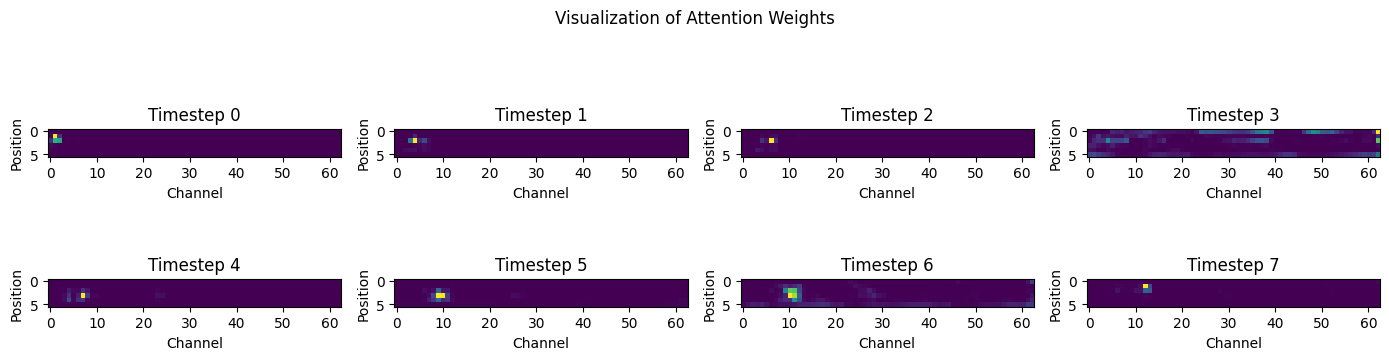

In [249]:
plot_weights(attention, num_timesteps=8)

In [250]:
def weight_resize(weight_array, target_shape=(64, 256)):

    target_rows, target_cols = target_shape
    orig_rows, orig_cols = weight_array.shape
    row_scale = target_rows / orig_rows
    col_scale = target_cols / orig_cols
    resized_weight = np.zeros(target_shape)
    for i in range(target_rows):
        for j in range(target_cols):
            orig_i = int(i / row_scale)
            orig_j = int(j / col_scale)
            resized_weight[i, j] = weight_array[orig_i, orig_j]
    return resized_weight

In [259]:
def plot_weights_overlay(image, attention, num_timesteps):

  fig, axs = plt.subplots(num_timesteps // 4, 4, figsize=(14, num_timesteps // 2))
  fig.suptitle('Visualization of Attention Weights Overlayed on Images')

  for timestep in range(num_timesteps):
      ax = axs[timestep // 4, timestep % 4]
      weights = attention[timestep]
      weight_resized = weight_resize(weights)

      min_val = np.min(weight_resized)
      max_val = np.max(weight_resized)
      weight_resized = (weight_resized - min_val) / (max_val - min_val)
      weight_resized = cv2.GaussianBlur(weight_resized, (3, 3), 0)

      weight_resized = weight_resized[:, :, np.newaxis]

      masked_image = image * (weight_resized + 0.3)

      im = ax.imshow(masked_image)
      ax.set_title(f'Timestep {timestep}: {predicted_words[idx][timestep]}')
      ax.set_xlabel('Channel')
      ax.set_ylabel('Position')

  plt.tight_layout()
  plt.show()

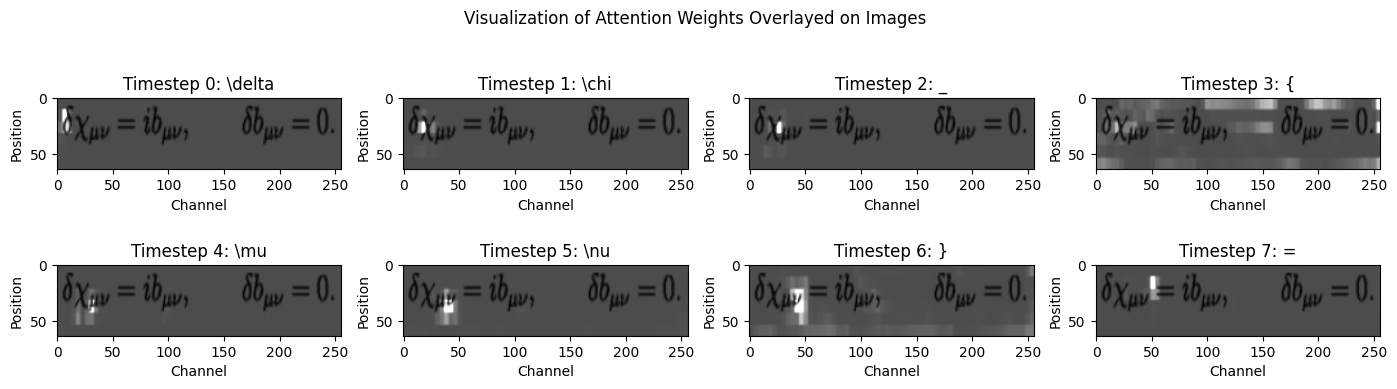

In [260]:
image = sample_img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
plot_weights_overlay(image, attention, num_timesteps=8)